# Lack of Robots with Horizontal Lines

In [291]:
import math

import networkx as nx
import matplotlib.pyplot as plt
import random as rand

## Settings

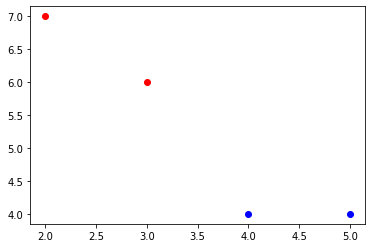

In [292]:
n=4
k=2
v=1
fv=2

low,high=0,10

rand.seed(3)
# agents = [(rand.uniform(low,high),rand.uniform(low,high)) for _ in range(n)]
# robots = [(rand.uniform(low,high),rand.uniform(low,high)) for _ in range(k)]

agents = [(2,7),(3,6)]
# (6,5),(7,7)]
robots = [(4,4),(5,4)]


plt.scatter(*zip(*agents),color='red')
plt.scatter(*zip(*robots),color='blue')

## Using Networkx

In [293]:
g = nx.DiGraph()

for i in range(len(robots)):
    g.add_node(f'r{i}', pos=robots[i], color='cyan')

for i in range(len(agents)):
    g.add_node(f'a{i}', pos=agents[i], color='pink')

[('r0', {'pos': (4, 4), 'color': 'cyan'}), ('r1', {'pos': (5, 4), 'color': 'cyan'}), ('a0', {'pos': (2, 7), 'color': 'pink'}), ('a1', {'pos': (3, 6), 'color': 'pink'})]
[]


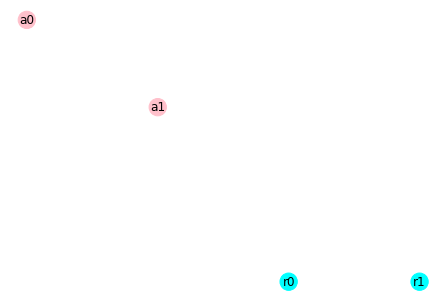

In [294]:
print(g.nodes(data=True))

print(g.edges(data=True))

nx.draw(g,
        pos=nx.get_node_attributes(g,'pos'),
        with_labels=True,
        node_color=nx.get_node_attributes(g, 'color').values())

## 1-Line Reachability Graph

In [295]:
def can_stop_on_line(r,a,h):
    x_a,y_a = a
    x_r,y_r = r
    t_a = (h-y_a) / v
    t_r = math.sqrt((x_a-x_r)**2 + (h-y_r)**2) / fv
    return t_r <= t_a

In [296]:
h = 10

g = nx.DiGraph()

# create robots
for i in range(len(robots)):
    g.add_node(f'r{i}', pos=robots[i], color='cyan')

# create agents divided to in and out
for i in range(len(agents)):
    pos_x,pos_y = agents[i]
    g.add_node(f'ai{i}', pos=(pos_x-0.5,pos_y), color='pink')
    g.add_node(f'ao{i}', pos=(pos_x+0.5,pos_y), color='pink')
    g.add_edge(f'ai{i}', f'ao{i}', weight=-1, capacity=1)

# add edges from robots to agents
for i in range(len(agents)):
    for j in range(len(robots)):
        if can_stop_on_line(robots[j], agents[i], h):
            g.add_edge(f'r{j}', f'ai{i}', weight=0, capacity=1)

# add edges between agents
for i in range(len(agents)):
    for j in range(len(agents)):
        if i is j:
            continue
        if can_stop_on_line((agents[i][0],h), (agents[j][0], agents[j][1]+(h-agents[i][1])) ,h):
            g.add_edge(f'ao{i}', f'ai{j}', weight=0, capacity=1)

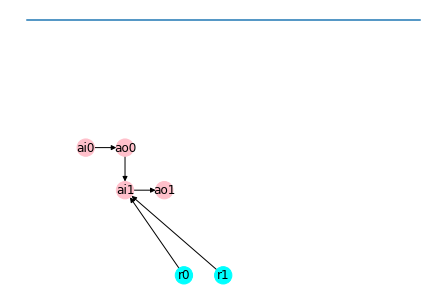

In [297]:
nx.draw(g,
        pos=nx.get_node_attributes(g,'pos'),
        with_labels=True,
        node_color=nx.get_node_attributes(g, 'color').values())

plt.plot([low,high],[h,h])

In [298]:
# add dummy source and target to use flow
for i in range(len(robots)):
    g.add_edge('s', f'r{i}', weight=0, capacity=1)
    g.add_edge(f'r{i}', 't', weight=0, capacity=1)

for i in range(len(agents)):
    g.add_edge(f'ao{i}', 't', weight=0, capacity=1)

flow = nx.max_flow_min_cost(g, 's', 't')

print(f'flow: {flow}')
for v1, vs in flow.items():
    for v2 in vs:
        if vs[v2]:
            print(f'{v1}->{v2}')
print(f'cost: {nx.cost_of_flow(g, flow)}')

flow: {'r0': {'ai1': 0, 't': 1}, 'r1': {'ai1': 1, 't': 0}, 'ai0': {'ao0': 0}, 'ao0': {'ai1': 0, 't': 0}, 'ai1': {'ao1': 1}, 'ao1': {'t': 1}, 's': {'r0': 1, 'r1': 1}, 't': {}}
r0->t
r1->ai1
ai1->ao1
ao1->t
s->r0
s->r1
cost: -1


## Multi-Line Reachability Graph

In [299]:
H = [2,4,9]

g = nx.DiGraph()

# create robots
for i in range(len(robots)):
    g.add_node(f'r{i}', pos=robots[i], color='cyan')

# create agents divided to in and out
for i in range(len(agents)):
    for h in H:
        g.add_node(f'{h}-ai{i}', color='pink')
        g.add_node(f'{h}-ao{i}', color='pink')
        g.add_edge(f'{h}-ai{i}', f'{h}-ao{i}', weight=-(max(H)-h+1), capacity=1)

# add edges from robots to agents
for i in range(len(agents)):
    for j in range(len(robots)):
        for h in H:
            if can_stop_on_line(robots[j], agents[i], h):
                g.add_edge(f'r{j}', f'{h}-ai{i}', weight=0, capacity=1)

# add edges between agents
for i in range(len(agents)):
    for j in range(len(agents)):
        if i is j:
            continue
        for h1 in H:
            for h2 in H:
                if can_stop_on_line((agents[i][0],h1), (agents[j][0], agents[j][1]+(h1-agents[i][1])) ,h2):
                    g.add_edge(f'{h}-ao{i}', f'{h}-ai{j}', weight=0, capacity=1)

{('r0', '9-ai1'): Text(0.8117448014372384, -0.3909157903806372, '0'),
 ('r1', '9-ai1'): Text(0.7622292264775327, -0.17397391310468435, '0'),
 ('2-ai0', '2-ao0'): Text(0.4230053811285948, 0.8783797178452828, '-8'),
 ('4-ai0', '4-ao0'): Text(-0.42300537474238287, 0.8783797178452828, '-6'),
 ('9-ai0', '9-ao0'): Text(-0.9504844250402944, 0.2169418823837948, '-1'),
 ('9-ao0', '9-ai1'): Text(-0.1882551943052871, -0.3909158340920253, '0'),
 ('2-ai1', '2-ao1'): Text(-0.7622292349924819, -0.60785766765659, '-8'),
 ('4-ai1', '4-ao1'): Text(1.0643686529365759e-08, -0.9749278790540411, '-6'),
 ('9-ai1', '9-ao1'): Text(0.7622292264775327, -0.60785766765659, '-1'),
 ('9-ao1', '9-ai0'): Text(-4.257474595092958e-09, 4.8819230102914446e-08, '0')}

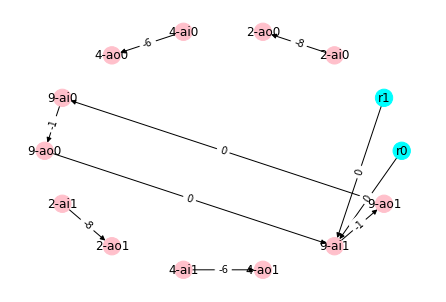

In [300]:
pos = nx.circular_layout(g)
nx.draw(g,
        pos=pos,
        with_labels=True,
        node_color=nx.get_node_attributes(g, 'color').values())

labels = nx.get_edge_attributes(g,'weight')
nx.draw_networkx_edge_labels(g,pos,edge_labels=labels)

In [301]:
# add dummy source and target to use flow
for i in range(len(robots)):
    g.add_edge('s', f'r{i}', weight=0, capacity=1)
    g.add_edge(f'r{i}', 't', weight=0, capacity=1)

for i in range(len(agents)):
    for h in H:
        g.add_edge(f'{h}-ao{i}', 't', weight=0, capacity=1)

flow = nx.max_flow_min_cost(g, 's', 't')

print(f'flow: {flow}')
for v1, vs in flow.items():
    for v2 in vs:
        if vs[v2]:
            print(f'{v1}->{v2}')
print(f'cost: {nx.cost_of_flow(g, flow)}')

flow: {'r0': {'9-ai1': 0, 't': 1}, 'r1': {'9-ai1': 1, 't': 0}, '2-ai0': {'2-ao0': 0}, '2-ao0': {'t': 0}, '4-ai0': {'4-ao0': 0}, '4-ao0': {'t': 0}, '9-ai0': {'9-ao0': 1}, '9-ao0': {'9-ai1': 0, 't': 1}, '2-ai1': {'2-ao1': 0}, '2-ao1': {'t': 0}, '4-ai1': {'4-ao1': 0}, '4-ao1': {'t': 0}, '9-ai1': {'9-ao1': 1}, '9-ao1': {'9-ai0': 1, 't': 0}, 's': {'r0': 1, 'r1': 1}, 't': {}}
r0->t
r1->9-ai1
9-ai0->9-ao0
9-ao0->t
9-ai1->9-ao1
9-ao1->9-ai0
s->r0
s->r1
cost: -2
